In [2]:
import sys
sys.path.append('src')
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [56]:
# Load into Dask
import dask.dataframe as dd
import numpy as np
import glob

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
            ]
sfreq = 200
eeg_ids = metadata['eeg_id'].to_list()

ddf_list = []
for eeg_id in eeg_ids:
  f_name = f'data/eeg/{eeg_id}.parquet'
  temp_ddf = dd.read_parquet(f_name).drop('EKG', axis=1)[channel_order]
  temp_ddf['eeg_id'] = str(eeg_id)
  temp_ddf = temp_ddf.set_index('eeg_id')
  ddf_list.append(temp_ddf)

ddf = dd.concat(ddf_list)
ddf


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [57]:
## MNE setup
df = ddf.loc['4454049'].compute()

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
4454049,0.140000,0.610000,-26.889999,-6.300000,3.610000,8.660000,-14.260000,-5.830000,-8.230000,-14.010000,-18.190001,-13.47,-19.049999,-3.160000,9.590000,-25.230000,-50.459999,-23.389999,-93.830002
4454049,3.310000,0.810000,-16.090000,1.950000,12.300000,13.690000,-9.230000,3.090000,-0.050000,-5.860000,-11.630000,-6.06,-12.870000,4.260000,17.170000,-16.719999,-41.240002,-16.230000,-84.320000
4454049,-5.790000,-6.630000,-24.820000,-6.710000,2.960000,2.170000,-16.610001,-13.490000,-12.240000,-18.209999,-22.360001,-15.36,-25.780001,-7.350000,6.630000,-26.400000,-51.610001,-27.370001,-93.379997
4454049,0.240000,-0.470000,-17.120001,-2.140000,7.430000,6.800000,-16.219999,-6.450000,-6.660000,-12.400000,-19.980000,-12.79,-23.360001,-2.100000,11.930000,-21.700001,-48.630001,-23.950001,-88.779999
4454049,9.710000,3.580000,-8.060000,4.130000,13.690000,10.710000,-9.170000,1.820000,1.330000,-4.770000,-14.560000,-7.05,-17.930000,4.660000,19.370001,-15.010000,-42.509998,-19.670000,-82.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454049,-34.590000,-37.759998,-66.010002,-32.939999,-22.629999,-21.040001,-22.480000,-49.470001,-35.200001,-42.590000,-27.510000,-3.56,-34.380001,-20.530001,4.060000,-31.870001,-52.730000,-25.219999,-115.889999
4454049,-26.500000,-27.090000,-56.160000,-23.700001,-14.720000,-14.580000,-15.180000,-41.560001,-29.980000,-36.020000,-23.320000,0.85,-30.770000,-17.379999,8.940000,-27.160000,-47.880001,-21.100000,-112.639999
4454049,-28.900000,-27.690001,-58.509998,-22.139999,-16.910000,-15.350000,-16.320000,-44.320000,-30.230000,-36.570000,-23.290001,1.76,-34.349998,-19.459999,8.020000,-25.940001,-47.110001,-23.610001,-114.279999


Creating RawArray with float64 data, n_channels=19, n_times=12400
    Range : 0 ... 12399 =      0.000 ...    61.995 secs
Ready.


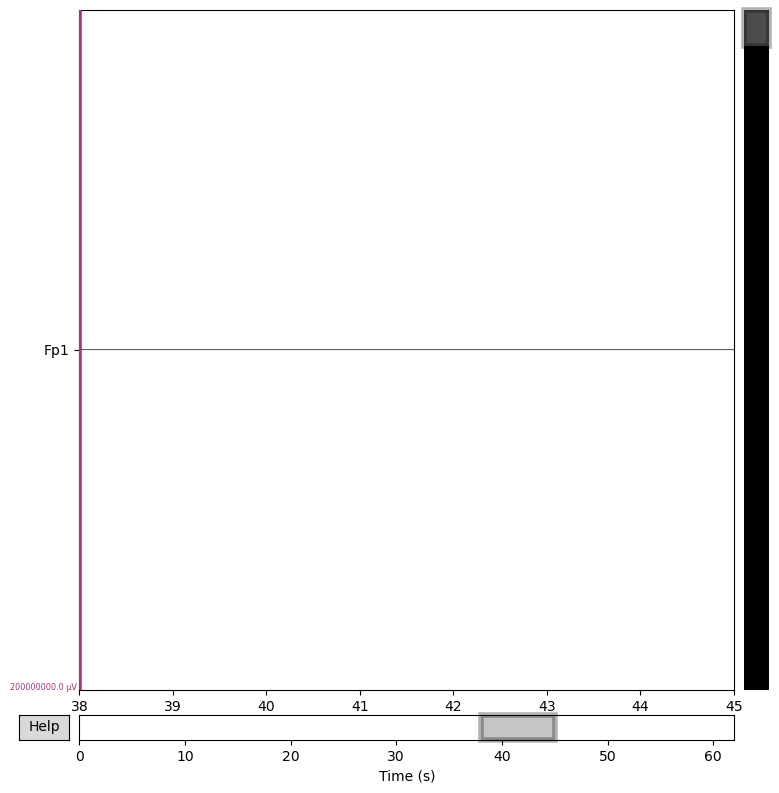

Applying baseline correction (mode: mean)


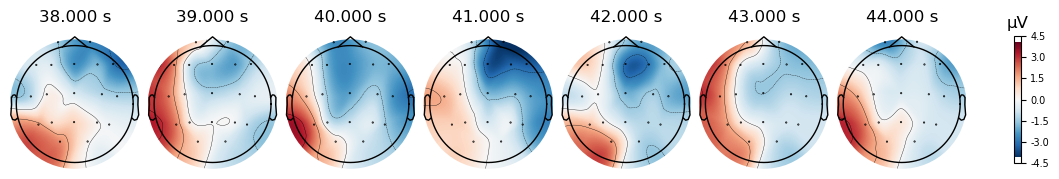

In [11]:
# Visualize
from visualize import VisualizeEEG

raw_df = ddf.partitions[2].compute()
vis_eeg = VisualizeEEG(raw_df)

# plot signal channels
vis_eeg.plot_signal(start=38, duration=7, n_channels = 1)

# plot topographic map
vis_eeg.plot_topomap(start=38, end=45, delta=1)